# Load Individual Household Electric Power Consumption
https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption

## Readme
- https://medium.com/@ottaviocalzone/an-intuitive-explanation-of-lstm-a035eb6ab42c
- https://www.youtube.com/watch?v=b61DPVFX03I

In [1]:
import os
import torch
from support import EnergyConsumptionDataset, EnergyConsumptionModule, build_loaders, demo_model_shapes, \
    plot_convergence, train_and_evaluate, plot_predictions_grid, plot_mse_horizon

In [2]:
data_folder = "local_data/cache"
if not os.path.exists(data_folder):
    os.makedirs(data_folder, exist_ok=True)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [4]:
all_data = EnergyConsumptionDataset(history_samples=24 * 14, horizon_samples=24 * 3, scale=True, train_fraction=0.9)
print("data length: ", len(all_data))
print("number of channels: ", all_data.number_of_channels)

data length:  2048873
number of channels:  7


# Explore dataset

In [5]:
all_data.data_features.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [6]:
train_dataset, test_dataset, train_loader, test_loader = build_loaders(all_data, train_fraction=0.9, batch_size_train=200, batch_size_eval=2000)

In [7]:
model = EnergyConsumptionModule(input_dim=all_data.number_of_channels, output_dim=all_data.horizon_samples)

In [8]:
demo_model_shapes(model, train_loader)

x: (200, 7, 336), model(x): (200, 72), y: (200, 7, 72)


In [9]:
checkpoint_file_name = os.path.join(data_folder, "ERAdmission-CNN-LSTM-Fusion.checkpoint.pt")
model, progress_log, test_accuracy, test_loader = train_and_evaluate(model, train_dataset, test_dataset, device=device, n_epochs=1, batch_size=200, lr=1e-3, checkpoint_file_name=checkpoint_file_name)


2 of 1. time=2562.19sec. Loss: 0.5923.Train accuracy: 41.4250. Validate accuracy: -1.0000


\\192.168.0.41\home\workspace\machine-learning\autoencoder_lstm\energy_consumption\support\utilities.py:97: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


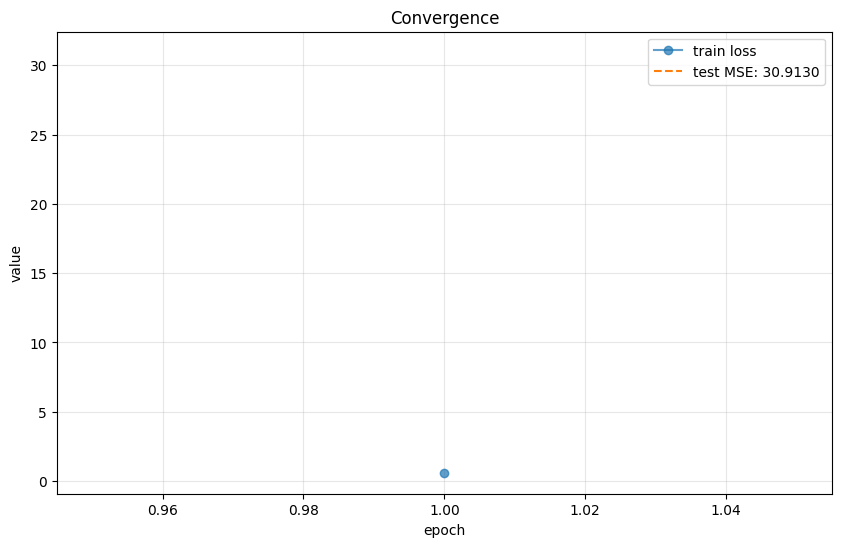

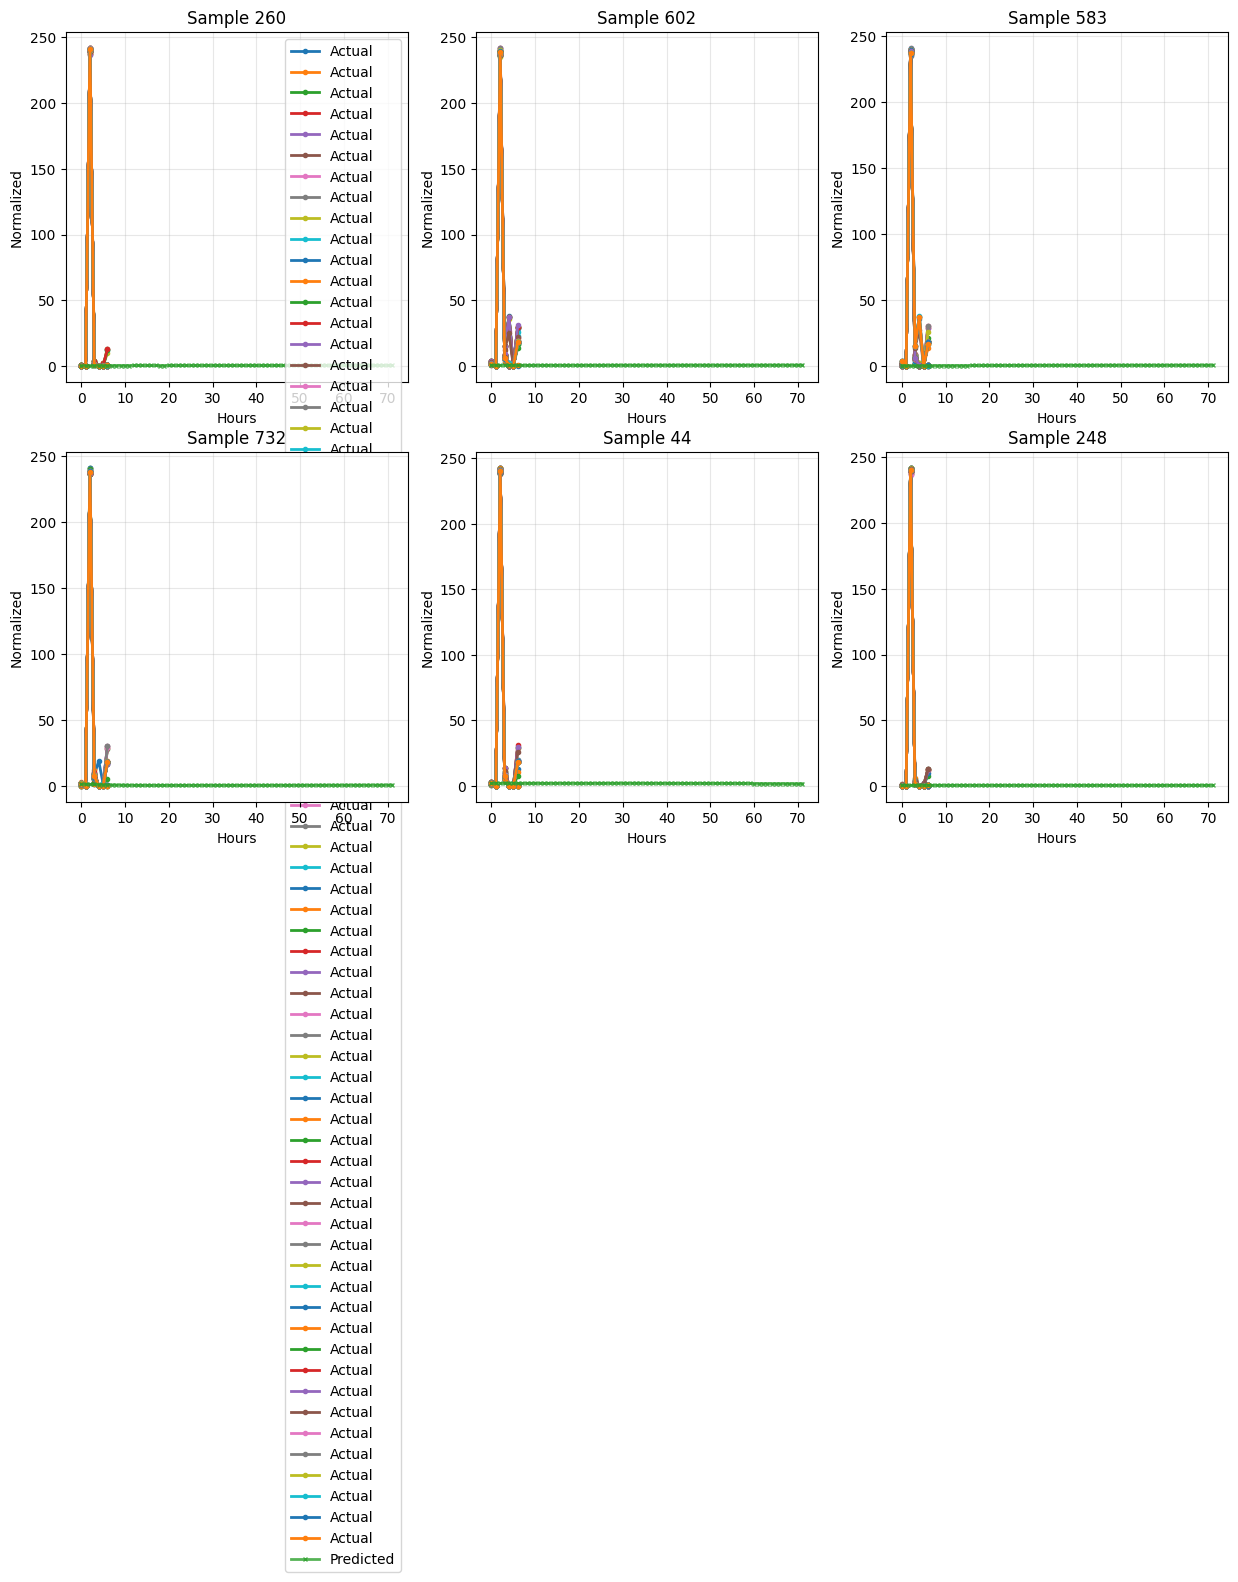

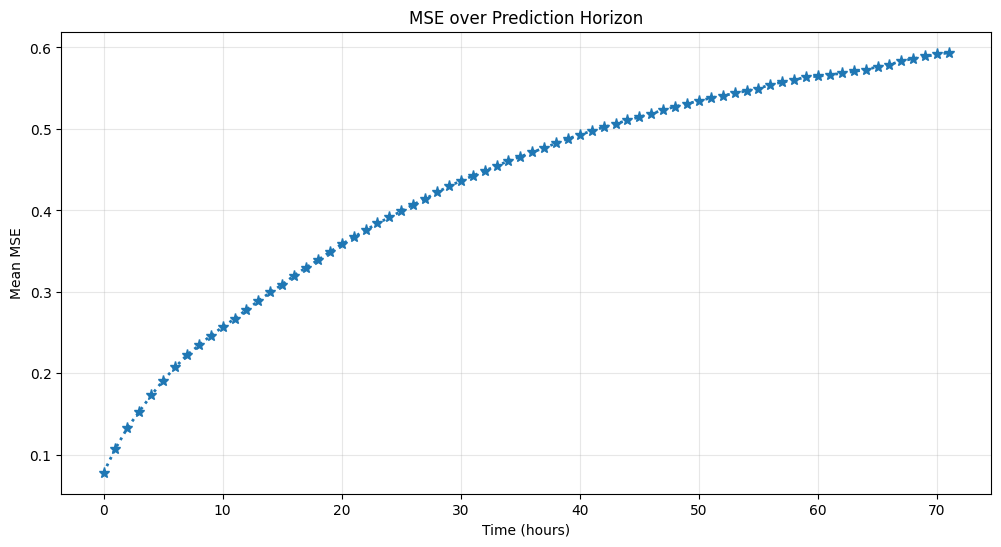

In [10]:
plot_convergence(progress_log, test_accuracy)
plot_predictions_grid(model, test_loader, device=device, n=6)
plot_mse_horizon(model, test_loader, all_data.horizon_samples, device=device)

# Prediction Examples
Below are small, focused examples showing how to run predictions with the trained `model` and `test_loader`.
Each code block is a single, logical step: prepare batch, run prediction, compute simple metrics, and plot results.

In [12]:
# 1) Prepare a small batch for inference
model.eval()
with torch.no_grad():
    X_all, y_all = next(iter(test_loader))
    # move inputs to device if available
    X_all = X_all.to(device) if 'device' in globals() else X_all
    n_samples = min(6, X_all.shape[0])
    X_sample = X_all[:n_samples]
    y_true = y_all[:n_samples].cpu()
    # reduce to primary channel if necessary: (batch, channels, horizon) -> (batch, horizon)
    if y_true.ndim == 3:
        y_true = y_true[:, 0, :]
    print('Prepared', n_samples, 'samples ->', 'X_sample', X_sample.shape, 'y_true', y_true.shape)

Prepared 6 samples -> X_sample torch.Size([6, 7, 336]) y_true torch.Size([6, 72])


In [13]:
# 2) Run prediction on the small batch and prepare results for plotting
with torch.no_grad():
    y_pred = model(X_sample)
    # model may return shape (batch, channels, horizon) or (batch, horizon)
    if y_pred.ndim == 3:
        y_pred = y_pred[:, 0, :]
    y_pred = y_pred.cpu()
print('y_pred shape', y_pred.shape)

y_pred shape torch.Size([6, 72])


In [14]:
# 3) Compute simple MSE metrics on the small batch
mse_per_sample = ((y_pred - y_true) ** 2).mean(dim=1)
print('MSE per sample:', mse_per_sample.numpy())
print('Mean MSE (batch):', float(mse_per_sample.mean()))

MSE per sample: [0.1286509  0.12333112 0.12469821 0.13017659 0.12201432 0.12833984]
Mean MSE (batch): 0.1262018382549286


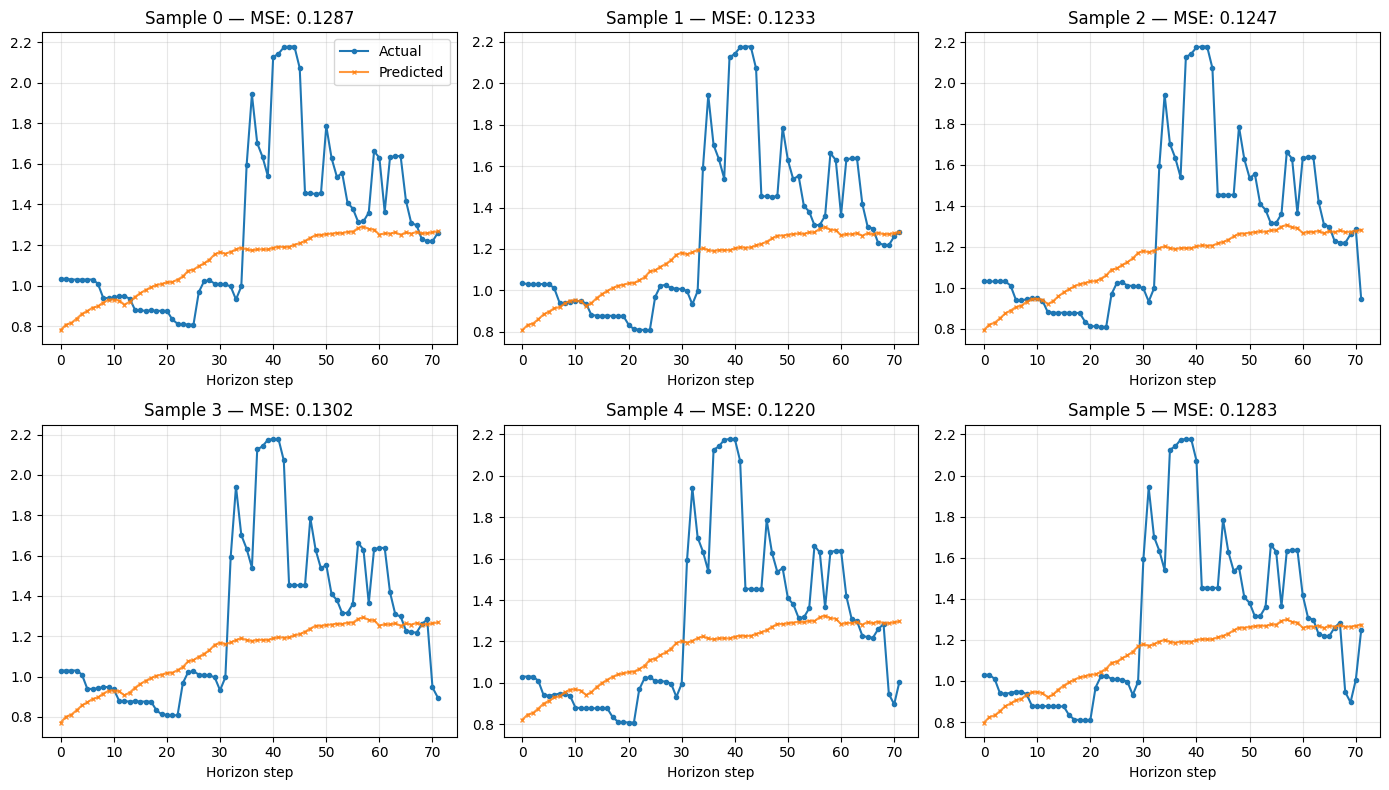

In [15]:
# 4) Plot actual vs predicted for the small batch (easy visual check)
import matplotlib.pyplot as plt
rows, cols = 2, 3
plt.figure(figsize=(14, 8))
for i in range(y_pred.shape[0]):
    plt.subplot(rows, cols, i + 1)
    plt.plot(y_true[i], label='Actual', marker='o', markersize=3)
    plt.plot(y_pred[i], label='Predicted', marker='x', markersize=3, alpha=0.8)
    plt.xlabel('Horizon step')
    plt.grid(True, alpha=0.3)
    plt.title(f'Sample {i} — MSE: {mse_per_sample[i]:0.4f}')
    if i == 0:
        plt.legend()
plt.tight_layout()